In [54]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow import keras
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, Flatten, Conv2D, Dropout, MaxPooling2D
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model
import plotly.graph_objs as go
from plotly import tools
import os
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

# Import dataset

In [55]:
train_data = pd.read_csv('../data/fashion-mnist_train.csv')
test_data = pd.read_csv('../data/fashion-mnist_test.csv')
labels = {0 : "T-shirt/top", 1: "Trouser", 2: "Pullover", 3: "Dress", 4: "Coat",
          5: "Sandal", 6: "Shirt", 7: "Sneaker", 8: "Bag", 9: "Ankle Boot"}
NUM_CLASSES = 10
IMG_ROWS = 28
IMG_COLS = 28

# Explore dataset

In [56]:
print('Fashion MNIST train - rows:', train_data.shape[0], 'columns', train_data.shape[1])
print('Fashion MNIST test - rows:', test_data.shape[0], 'columns', test_data.shape[1])

Fashion MNIST train - rows: 60000 columns 785
Fashion MNIST test - rows: 10000 columns 785


In [57]:
def get_classes_distribution(data):
    label_counts = data['label'].value_counts()
    # label_counts是Series数据类型，不具有.keys（）方法
    total_samples = len(data)
    for i in range(len(label_counts)):
        label = labels[label_counts.index[i]]
        count = label_counts.values[i]
        percent = (count / total_samples) * 100
        print("{:<20s}: {} or {}%".format(label, count, percent))
        # ‘<': forces the output field to be left-aligned within the available space
        # {:<20s} means left aligned with width 20
print('------train_data_distribution------')
print(get_classes_distribution(train_data))
print('------test_data_distribution------')
print(get_classes_distribution(test_data))

------train_data_distribution------
T-shirt/top         : 6000 or 10.0%
Trouser             : 6000 or 10.0%
Pullover            : 6000 or 10.0%
Dress               : 6000 or 10.0%
Coat                : 6000 or 10.0%
Sandal              : 6000 or 10.0%
Shirt               : 6000 or 10.0%
Sneaker             : 6000 or 10.0%
Bag                 : 6000 or 10.0%
Ankle Boot          : 6000 or 10.0%
None
------test_data_distribution------
T-shirt/top         : 1000 or 10.0%
Bag                 : 1000 or 10.0%
Trouser             : 1000 or 10.0%
Ankle Boot          : 1000 or 10.0%
Pullover            : 1000 or 10.0%
Dress               : 1000 or 10.0%
Coat                : 1000 or 10.0%
Sandal              : 1000 or 10.0%
Shirt               : 1000 or 10.0%
Sneaker             : 1000 or 10.0%
None


# Preprocess and Inspect Dataset
y_label: one-hot encoding  
image value: reshape it to be compatible with tensorflow dataformate && normalize

In [65]:
def data_preprocessing(raw):
    out_y = keras.utils.to_categorical(raw.label, NUM_CLASSES)
    num_images = raw.shape[0]
    x_as_array = raw.values[:,1:]
    x_shaped_array = x_as_array.reshape(num_images, IMG_ROWS, IMG_COLS, 1)
    out_x = x_shaped_array / 255
    return out_x, out_y
X, y = data_preprocessing(train_data)
X_test, y_test = data_preprocessing(test_data)
print('Object Type: ', type(X))
print('Trainning Set, X - rows:', X.shape[0], 'columns', X.shape[1])
print('Trainning Set, y - rows:', y.shape[0], 'columns', y.shape[1])
print('Test Set, X_test - rows:', X_test.shape[0], 'columns', X_test.shape[1])
print('Test Set, y_test - rows:', y_test.shape[0], 'columns', y_test.shape[1])
print(y[:5])

Object Type:  <class 'numpy.ndarray'>
Trainning Set, X - rows: 60000 columns 28
Trainning Set, y - rows: 60000 columns 10
Test Set, X_test - rows: 10000 columns 28
Test Set, y_test - rows: 10000 columns 10
[[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]]


# Model Constant Value

In [59]:
TEST_SIZE = 0.2
RANDOM_STATE = 2018
#Model
NO_EPOCHS = 40
BATCH_SIZE = 128

# Split and Inspect Dataset 

In [60]:
# Split train_data into train and validation set
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE)
# precessed train,validation and test set info
print('Fashion MNIST train - rows:', X_train.shape[0]," columns:", X_train.shape[1:4])
print("Fashion MNIST valid -  rows:",X_val.shape[0]," columns:", X_val.shape[1:4])
print("Fashion MNIST test -  rows:",X_test.shape[0]," columns:", X_test.shape[1:4])

Fashion MNIST train - rows: 48000  columns: (28, 28, 1)
Fashion MNIST valid -  rows: 12000  columns: (28, 28, 1)
Fashion MNIST test -  rows: 10000  columns: (28, 28, 1)


# Build CNN model
Model type: Sequential model which adds layers using add method  
Layers: Conv2D, MaxPooling2D,Dropout, Flatten, Dense  
Conv2D: number of filters(kernels), kernel_size, activation,kernel_initializer(initial_value of the kernel), input_shape  MaxPooling2D: maximum pooling method is adopted  
Dropout:    help avoiding overfitting  
Flatten:    Commonly used in the transition from convolutional layer to the fully connected layer  
Dense:  the final layer(full connected)

In [61]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 kernel_initializer='he_normal',
                 input_shape=(IMG_ROWS, IMG_COLS, 1)))
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.25))
model.add(Conv2D(64,
                 kernel_size=(3, 3),
                 activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(Dropout(0.4))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(NUM_CLASSES, activation='softmax'))


## Inspect/check the model- .summery()

In [62]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 3, 3, 128)        

# Compile and Fit CNN model

In [66]:
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer='adam',
              metrics=['accuracy'])

In [81]:
history = model.fit(X_train, y_train,
                  batch_size=BATCH_SIZE,
                  epochs=NO_EPOCHS,
                  verbose=1,
                  validation_data=(X_val, y_val))

Epoch 1/40
375/375 [==============================] - 24s 63ms/step - loss: 0.1676 - accuracy: 0.9370 - val_loss: 0.2206 - val_accuracy: 0.9218
Epoch 2/40
375/375 [==============================] - 21s 55ms/step - loss: 0.1642 - accuracy: 0.9385 - val_loss: 0.2197 - val_accuracy: 0.9248
Epoch 3/40
375/375 [==============================] - 21s 56ms/step - loss: 0.1616 - accuracy: 0.9390 - val_loss: 0.2260 - val_accuracy: 0.9233
Epoch 4/40
375/375 [==============================] - 24s 63ms/step - loss: 0.1645 - accuracy: 0.9368 - val_loss: 0.2249 - val_accuracy: 0.9245
Epoch 5/40
375/375 [==============================] - 26s 70ms/step - loss: 0.1638 - accuracy: 0.9374 - val_loss: 0.2215 - val_accuracy: 0.9244
Epoch 6/40
375/375 [==============================] - 26s 68ms/step - loss: 0.1575 - accuracy: 0.9398 - val_loss: 0.2231 - val_accuracy: 0.9250
Epoch 7/40
375/375 [==============================] - 26s 69ms/step - loss: 0.1634 - accuracy: 0.9388 - val_loss: 0.2143 - val_accuracy:

# Plot the accuracy and loss during training progress

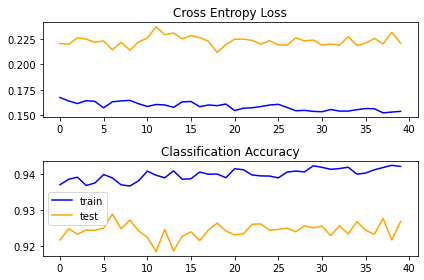

In [89]:
import sys # 涉及系统中文件
from matplotlib import pyplot
# plot loss
pyplot.subplot(211)
pyplot.title('Cross Entropy Loss')
pyplot.plot(history.history['loss'], color='blue', label='train')
pyplot.plot(history.history['val_loss'], color='orange', label='test')
# plot accuracy
pyplot.subplot(212)
pyplot.title('Classification Accuracy')
pyplot.plot(history.history['accuracy'], color='blue', label='train')
pyplot.plot(history.history['val_accuracy'], color='orange', label='test')
pyplot.tight_layout()
pyplot.legend()
pyplot.show()

# Score of Test Set

In [84]:
score = model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.2099369317293167
Test accuracy: 0.9279999732971191


根据结果：
训练过程中loss值不下降，一直在震荡，但accuracy又挺高  
训练集也不下降，测试集也不下降，可能是这个模型结构不适应这个数据集，也可能是正则化过度，权重初始化方案有问题，激活函数，损失函数有问题。

# 重新调整模型
砍掉正则化层

In [91]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 kernel_initializer='he_normal',
                 input_shape=(IMG_ROWS, IMG_COLS, 1)))
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.25))
model.add(Conv2D(64,
                 kernel_size=(3, 3),
                 activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(Dropout(0.4))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(NUM_CLASSES, activation='softmax'))

In [92]:
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer='adam',
              metrics=['accuracy'])
history = model.fit(X_train, y_train,
                  batch_size=BATCH_SIZE,
                  epochs=NO_EPOCHS,
                  verbose=1,
                  validation_data=(X_val, y_val))

Epoch 1/40
375/375 [==============================] - 24s 64ms/step - loss: 0.6971 - accuracy: 0.7386 - val_loss: 0.4568 - val_accuracy: 0.8355
Epoch 2/40
375/375 [==============================] - 25s 66ms/step - loss: 0.4405 - accuracy: 0.8379 - val_loss: 0.3690 - val_accuracy: 0.8641
Epoch 3/40
375/375 [==============================] - 25s 66ms/step - loss: 0.3822 - accuracy: 0.8589 - val_loss: 0.3187 - val_accuracy: 0.8825
Epoch 4/40
375/375 [==============================] - 26s 69ms/step - loss: 0.3466 - accuracy: 0.8725 - val_loss: 0.2991 - val_accuracy: 0.8914
Epoch 5/40
375/375 [==============================] - 25s 68ms/step - loss: 0.3208 - accuracy: 0.8818 - val_loss: 0.2822 - val_accuracy: 0.8966
Epoch 6/40
375/375 [==============================] - 28s 74ms/step - loss: 0.3036 - accuracy: 0.8881 - val_loss: 0.2753 - val_accuracy: 0.9012
Epoch 7/40
375/375 [==============================] - 27s 71ms/step - loss: 0.2884 - accuracy: 0.8925 - val_loss: 0.2630 - val_accuracy:

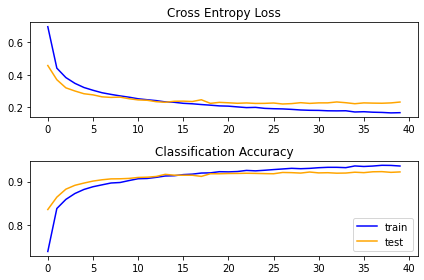

In [93]:
import sys # 涉及系统中文件
from matplotlib import pyplot
# plot loss
pyplot.subplot(211)
pyplot.title('Cross Entropy Loss')
pyplot.plot(history.history['loss'], color='blue', label='train')
pyplot.plot(history.history['val_loss'], color='orange', label='test')
# plot accuracy
pyplot.subplot(212)
pyplot.title('Classification Accuracy')
pyplot.plot(history.history['accuracy'], color='blue', label='train')
pyplot.plot(history.history['val_accuracy'], color='orange', label='test')
pyplot.tight_layout()
pyplot.legend()
pyplot.show()

趋势线出来了，完美。